##### HW 4, Part 2, Start
### CSCI 4270 and 6270, Spring 2025

This is starter code for HW 4, Part 2. Most important is the definition of the Dataset object for loading, separately, the train, validation and test image sets. Students can use as much or as little of this as they wish and can modify it in anyway they'd like

In [106]:
import numpy as np
import os 
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [107]:
def is_image(fn):
    extensions = ['.jpg', '.jpeg', '.png']
    return any(fn.lower().endswith(ext) for ext in extensions)

def find_images_in_folder(folder_path, verbose=False):
    full_image_paths = []
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # Check if the file is an image
        if os.path.isfile(file_path) and is_image(filename):
            # Try opening the image
            try:
                im = Image.open(file_path)
                full_image_paths.append(file_path)
                if verbose:
                    print(f"Read image: {file_path}")
            except Exception as e:
                print(f"Error failed to read {filename}: {e}")
    print(f'Returing {len(full_image_paths)} image paths')
    return full_image_paths

folder_path = "hw4_data/valid/ocean"
full_paths = find_images_in_folder(folder_path, verbose=False)


Returing 150 image paths


In [108]:
'''
Provide a Dataset object for the five class dataset.
'''

# These are empirically determined values to optimize image intensity rescaling prior to training
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

'''
The Dataset class we write must include the __init__, __len__ and __getitem__ (subscripting) 
methods.
'''
class HW4_Dataset(Dataset):
    def __init__(self, path, class_names, new_size=None, verbose=False):
        '''
        Produce a list of the full image paths and class indices for all images
        in the given set (found along the path).  Record a transform to be
        applied by the __getitem__ method to each image.
        '''
        self.full_image_paths = []
        self.class_names = class_names
        self.gt_class_idx = []
        for idx, nm in enumerate(class_names):
            folder_path = os.path.join(path, nm)
            image_paths = find_images_in_folder(folder_path, verbose)
            self.full_image_paths += image_paths
            self.gt_class_idx += [idx] * len(image_paths)

        if new_size is not None:
            self.transform = transforms.Compose([transforms.Resize(new_size),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=MEAN, std=STD)])
        else:
            self.transform = transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.full_image_paths)

    def __getitem__(self, idx):
        fp = self.full_image_paths[idx]
        class_i = self.gt_class_idx[idx]
        im = Image.open(fp)
        im = self.transform(im)
        return im, class_i
        
        
class_names = ['grass', 'ocean', 'redcarpet', 'road', 'wheatfield']

# new_size = 60   # This reduces the original 240x360 images to 60x90.  Setting it to 240 leaves the images unchanged
new_size = None # Setting new_size to None keeps the original image size.
verbose = False

# Form all three datasets.
train_dataset = HW4_Dataset("hw4_data/train", class_names, new_size=new_size, verbose=verbose)
valid_dataset = HW4_Dataset("hw4_data/valid", class_names, new_size=new_size, verbose=verbose)
test_dataset = HW4_Dataset("hw4_data/test", class_names, new_size=new_size, verbose=verbose)


Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths


The validation dataset has 750 images
After the shuffle the 0th image has class index 1
Image shape is (240, 360, 3)


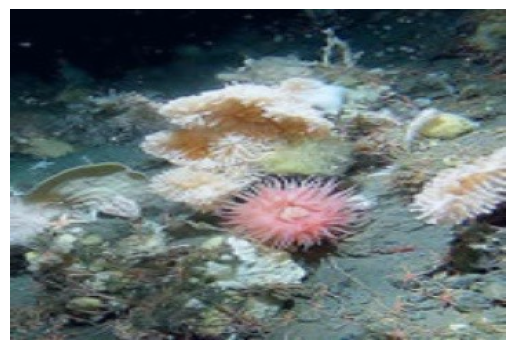

1


In [109]:
'''
Explore the constructed dataset
'''
import random
import matplotlib.pyplot as plt

# Find and output the number of images
n = len(valid_dataset)
print(f'The validation dataset has {n} images')

# Randomly shuffle the image indices
indices = list(range(n))
random.shuffle(indices)

# Get the image and the class id of the 0th image after the shuffle.
im, class_idx = valid_dataset[indices[0]]
print(f'After the shuffle the 0th image has class index {class_idx}')

# Convert the image from an array back to a numpy 3d array
im_np = im.numpy().transpose((1, 2, 0))
print(f'Image shape is {im_np.shape}')

# Before displaying the image rescale the intensities to be between 0 and 1
im_min = im_np.min()
im_max = im_np.max()
im_np = (im_np - im_min) / (im_max - im_min)

# Display the image
plt.imshow(im_np)
plt.axis('off')
plt.show()
print(class_idx)

In [113]:
class CNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)  # Adding dropout for regularization
        self.batch_norm1 = nn.BatchNorm2d(32)  # Adding batch normalization
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 60 * 90, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))  # Applying dropout before final layer
        x = self.fc2(x)
        return x




In [114]:
from torch.optim.lr_scheduler import CosineAnnealingLR

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, optimizer, and scheduler
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=len(class_names)).to(device)
model = nn.DataParallel(model, device_ids=[0, 1, 2, 3]) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-1)  # Adding L2 regularization
scheduler = CosineAnnealingLR(optimizer, T_max=1000) #1500 for 1k



Epoch 1/300, Train Loss: 1.4788, Train Acc: 55.20%, Val Loss: 0.7659, Val Acc: 70.93%
Model saved at epoch 1 with val acc: 70.93%
Epoch 2/300, Train Loss: 0.9917, Train Acc: 59.89%, Val Loss: 0.5875, Val Acc: 79.60%
Model saved at epoch 2 with val acc: 79.60%
Epoch 3/300, Train Loss: 0.9803, Train Acc: 58.80%, Val Loss: 0.6372, Val Acc: 78.80%
Epoch 4/300, Train Loss: 0.9855, Train Acc: 57.71%, Val Loss: 0.6582, Val Acc: 79.07%
Epoch 5/300, Train Loss: 1.0363, Train Acc: 56.71%, Val Loss: 0.7590, Val Acc: 74.67%
Epoch 6/300, Train Loss: 0.9473, Train Acc: 60.60%, Val Loss: 0.6620, Val Acc: 77.33%
Epoch 7/300, Train Loss: 0.9552, Train Acc: 60.14%, Val Loss: 0.6268, Val Acc: 78.13%
Epoch 8/300, Train Loss: 0.9239, Train Acc: 63.17%, Val Loss: 0.6061, Val Acc: 80.93%
Model saved at epoch 8 with val acc: 80.93%
Epoch 9/300, Train Loss: 0.9304, Train Acc: 63.09%, Val Loss: 0.6248, Val Acc: 78.80%
Epoch 10/300, Train Loss: 0.8401, Train Acc: 66.66%, Val Loss: 0.5425, Val Acc: 81.20%
Model s

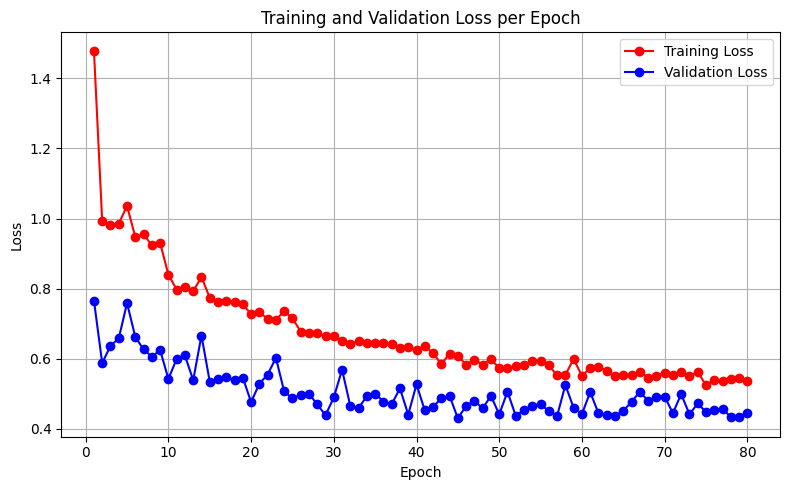

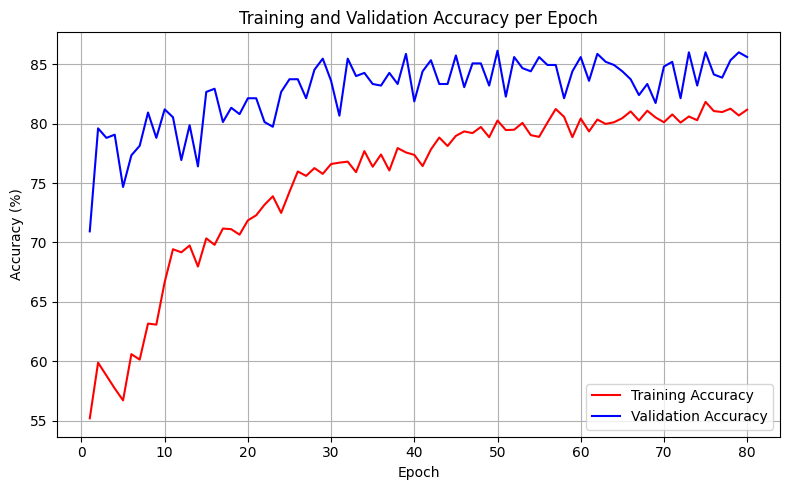

In [115]:
# Early stopping parameters
#epoch 200lr=0.0005,wd=1e-1,p=0.2 produces somehow decent score
model_path = 'best_model.pth'
early_stop_patience = 30
best_val_acc = -float("inf")
early_stop_counter = 0

train_accs=[]
train_losses=[]
val_accs=[]
val_losses=[]

# Training loop
epochs = 300
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_acc = 100 * val_correct / val_total
    val_loss /= len(valid_loader)

    val_accs.append(val_acc)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    scheduler.step()
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), model_path)  # Save the best model
        print(f"Model saved at epoch {epoch+1} with val acc: {val_acc:.2f}%")
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

epoch_idx = [i + 1 for i in range(len(train_accs))]

# --- Plot Loss ---
plt.figure(figsize=(8, 5))
plt.plot(epoch_idx, train_losses, 'r-o', label='Training Loss')
plt.plot(epoch_idx, val_losses, 'b-o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Accuracy ---
plt.figure(figsize=(8, 5))
plt.plot(epoch_idx, train_accs, 'r-', label='Training Accuracy')
plt.plot(epoch_idx, val_accs, 'b-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [116]:
def compute_accuracy(test_pairs, num_classes):
    correct = sum(1 for true, pred in test_pairs if true == pred)
    total = len(test_pairs)
    return correct / total if total > 0 else 0
import numpy as np

def compute_per_class_accuracy(test_pairs, num_classes):
    correct_per_class = np.zeros(num_classes)
    total_per_class = np.zeros(num_classes)

    for true, pred in test_pairs:
        if true == pred:
            correct_per_class[true] += 1
        total_per_class[true] += 1  # Count instances of each class

    # Avoid division by zero by using np.where
    return np.round(np.where(total_per_class > 0, correct_per_class / total_per_class, 0),2)

def compute_confusion_matrix(test_pairs, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)

    for true, pred in test_pairs:
        cm[true, pred] += 1  # Increment the corresponding (true, pred) cell

    return cm


In [117]:
# Evaluate model
model_path = 'best_model.pth'
model.load_state_dict(torch.load(model_path))

y_pred=[]
gt=[]
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted)
        gt.append(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


#print(f'Test Accuracy: {100 * correct / total:.2f}%')
# Flatten and move to CPU
gt_all = torch.cat(gt).cpu().numpy()
y_pred_all = torch.cat(y_pred).cpu().numpy()

test_pairs = list(zip(gt_all, y_pred_all))

num_classes = len(class_names)
accuracy = compute_accuracy(test_pairs, num_classes)
print(f'accuracy: {accuracy:.2f}')

per_class_accuracy = compute_per_class_accuracy(test_pairs, num_classes)
print()
print('Per class accuracy')
for i, acc in enumerate(per_class_accuracy):
    print(f'{i}: {acc:4.2f}')

cm = compute_confusion_matrix(test_pairs, num_classes)
print(f'\nConfusion matrix')
for i in range(num_classes):
    print(f'{i:2d}:', end='')
    for j in range(num_classes):
        print(f' {cm[i, j]:2d}', end='')
    print()

/tmp/ipykernel_958074/4105582626.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


accuracy: 0.82

Per class accuracy
0: 0.75
1: 0.77
2: 0.91
3: 0.82
4: 0.85

Confusion matrix
 0: 113  1  0 14 22
 1:  8 115  2 16  9
 2:  3  1 136  7  3
 3: 10  7  0 123 10
 4: 14  2  1  5 128


In [119]:
n = len(test_dataset)

# Randomly shuffle the image indices
indices = list(range(n))
random.shuffle(indices)

for i in range(10):
    im, class_idx = test_dataset[indices[i]]
    print(class_idx)
#class_names = ['grass', 'ocean', 'redcarpet', 'road', 'wheatfield']

1
2
0
3
2
0
3
2
4
2


After the shuffle the 0th image has class index 2
Image shape is (240, 360, 3)


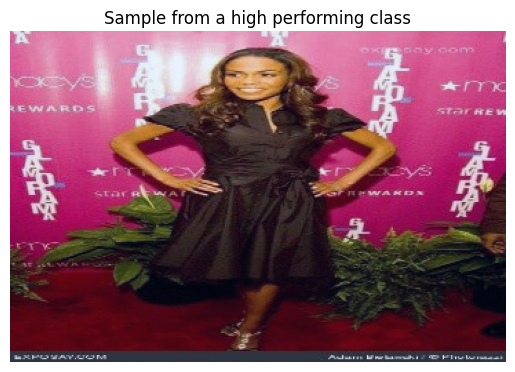

2


In [123]:


im, class_idx = test_dataset[indices[1]]
print(f'After the shuffle the 0th image has class index {class_idx}')

# Convert the image from an array back to a numpy 3d array
im_np = im.numpy().transpose((1, 2, 0))
print(f'Image shape is {im_np.shape}')

# Before displaying the image rescale the intensities to be between 0 and 1
im_min = im_np.min()
im_max = im_np.max()
im_np = (im_np - im_min) / (im_max - im_min)

# Display the image
plt.imshow(im_np)
plt.axis('off')
plt.title('Sample from a high performing class')
plt.savefig('redcarpet_bg.jpg')
plt.show()
print(class_idx)